In [2]:
import math
from typing import Tuple
from numba import cuda
import numpy as np
from numba.cuda.random import create_xoroshiro128p_states, xoroshiro128p_normal_float64
import matplotlib.pyplot as plt
from scipy.stats import norm
import timeit

## Monte Carlo for SABR model. GPU version.

In [3]:
def get_value(F0:float,T:float,alpha0:float,beta:float,nu:float,
    rho:float,  K: float, Nstep:int, Ntrace: int)->Tuple[float,float]:




    payoff_holder = np.zeros(Ntrace)
    cu_payoff_holder = cuda.to_device(payoff_holder)

    tpb = 512
    bpg = (Ntrace + (tpb - 1)) // tpb
    rng_states = create_xoroshiro128p_states(tpb * bpg,
                                             seed=np.random.randint(1,10 ** 5))

    cu_get_value[bpg, tpb](F0, T,
                           alpha0, beta, nu, rho, K,
                           Nstep, Ntrace,
                           cu_payoff_holder,
                           rng_states)
    cu_payoff_holder.to_host()

    return float(np.mean(payoff_holder)), np.std(payoff_holder) / np.sqrt(Ntrace)

@cuda.jit
def cu_get_value(F0, T,  alpha0, beta, nu, rho, K, Nstep, Ntrace, payoff_holder,rng_states):

    itrace = cuda.grid(1)  # Index for trace

    F1 = F0
    F2 = F0
    alpha1 = alpha0
    alpha2 = alpha0

    if itrace < Ntrace:
        #if itrace%10==0:
        #    clear_output(wait=True)
        #    print("Trace #" + str(itrace))

        dt = T / Nstep
        #dt_list = math.flip(math.diff(math.geomspace(1e-5, self.T, num=self.Nstep),prepend=[0]))

        for istep in range(Nstep):
            X1 = xoroshiro128p_normal_float64(rng_states, itrace)
            X2 = xoroshiro128p_normal_float64(rng_states, itrace)
            Z=rho*X1+math.sqrt(1.-rho**2.)*X2
            
            F1 += alpha1*(math.pow(F1,beta))*math.sqrt(dt)*X1
            alpha1 += nu*alpha1*math.sqrt(dt)*Z
            F2 += alpha2*(math.pow(F2,beta))*math.sqrt(dt)*X1*(-1.)
            alpha2 += nu*alpha2*math.sqrt(dt)*Z*(-1.)
        #plt.plot(F1list,'b')

        payoff1 = max(F1 - K,0.)
        payoff2 = max(F2 - K,0.)

        payoff_holder[itrace] = (payoff1 + payoff2)/2.

## Calculated implied volatility from value

In [5]:
def bs_call(K:float, F0:float, T:float, vol:float)->float:
      d1 = (np.log(F0/K) + (0.5*vol**2)*T) / (vol*np.sqrt(T))
      d2 = d1 - vol * np.sqrt(T)
      return F0 * norm.cdf(d1) -  K*norm.cdf(d2)
def bs_vega(K:float, F0:float, T:float, vol:float):
      d1 = (np.log(F0 / K) + (0.5 * vol ** 2) * T) / (vol* np.sqrt(T))
      return F0 * norm.pdf(d1) * np.sqrt(T)

def find_vol(target_value:float, F0:float , K:float, T:float):
    MAX_ITERATIONS = 200
    PRECISION = 1.0e-6
    sigma = 0.5
    for i in range(0, MAX_ITERATIONS):
        price = bs_call(K=K, F0=F0, T=T, vol=sigma)
        vega = bs_vega(K=K, F0=F0, T=T, vol=sigma)
        diff = target_value - price  # our root
        if (abs(diff) < PRECISION):
            return sigma
        sigma = sigma + diff/vega # f(x) / f'(x)
    return sigma


def im_vol(target_value:float,F0:float, T:float, K:float)->float:
    MAX_ITERATIONS = 10000
    PRECISION = 1.0e-6
    sig_u, sig_d = 2, 0.2
    sig = 0.5
    price = bs_call(K = K, F0=F0, T=T, vol=sig)
    err = target_value - price
    count = 0
    while abs(err)> PRECISION and count < MAX_ITERATIONS:
        if err > 0:
            sig_d = sig
            sig = (sig_u + sig_d)/2
        else:
            sig_u = sig
            sig = (sig_d + sig)/2
        price = bs_call(K = K,F0=F0, T=T, vol=sig)
        err = target_value - price
        count += 1
    return sig #


In [87]:
F0 = 1.0
T = 1.0
alpha0 = 0.35
beta = 0.25
nu = 1.0
rho = 0.25
K = 1.0
Nstep = 10000
Ntrace = 10000

mean_value,std_value = get_value(F0 = F0, T = T, alpha0 = alpha0, beta = beta, nu = nu,
    rho = rho, K=K, Nstep=Nstep, Ntrace=Ntrace)
print("mean value is " + str(mean_value))
print("std is " + str(std_value))

mean value is 0.1461410140437811
std is 0.0021737955017167216


K =0.5
K =0.6625
K =0.825
K =0.9875
K =1.15
K =1.3125
K =1.475
K =1.6375
K =1.8
Time:  4.083534699999291


Text(0, 0.5, 'volatility')

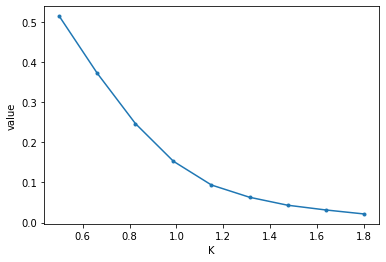

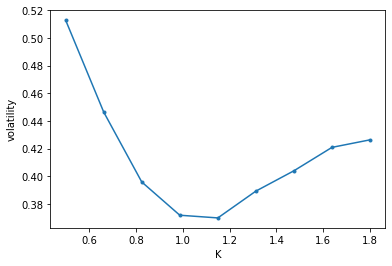

In [131]:
F0 = 1.0
T = 1.0
alpha0 = 0.35
beta = 0.25
nu = 1.0
rho = 0.25
K = 1.0
Nstep = 10000
Ntrace = 10000

vol_list = []
value_list = []
Klist = np.linspace(0.5,1.8,9)
start = timeit.default_timer()
for K in Klist:
    print("K =" +str(K))
    mean_value,std_value = get_value(F0 = F0, T = T, alpha0 = alpha0, beta = beta, nu = nu,
        rho = rho, K=K, Nstep=Nstep, Ntrace=Ntrace)
    value_list.append(mean_value)
    vol = find_vol(target_value = mean_value,F0=F0, T=T, K = K)
    vol_list.append(vol)
stop = timeit.default_timer()
print('Time: ', stop - start)
plt.plot(Klist,value_list,'.-')
plt.xlabel('K')
plt.ylabel('value')
plt.figure()
plt.plot(Klist,vol_list,'.-')
plt.xlabel('K')
plt.ylabel('volatility')

## F Dynamics

F = 0.8
F = 1.0
F = 1.2


Text(0, 0.5, 'implied volatility')

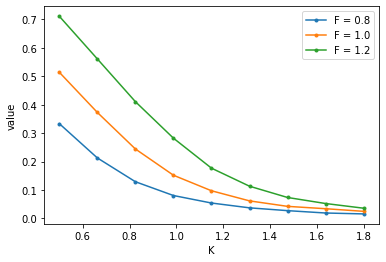

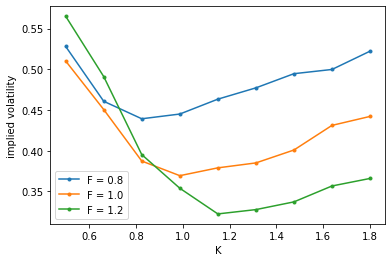

In [18]:
F0 = 1.0
T = 1.0
alpha0 = 0.35
beta = 0.25
nu = 1.0
rho = 0.25
K = 1.0
Nstep = 20000
Ntrace = 20000

Flist = np.linspace(0.8,1.2,3)
Klist = np.linspace(0.5,1.8,9)
vol_record3 = []
val_record3 = []
for F0 in Flist:
    print('F = ' + str(F0))
    vol_list = []
    val_list = []
    for K in Klist:
        mean_value,std_value = get_value(F0 = F0, T = T, alpha0 = alpha0, beta = beta, nu = nu,
        rho = rho, K=K, Nstep=Nstep, Ntrace=Ntrace)
        vol = find_vol(target_value = mean_value,F0=F0, T=T,K=K)
        vol_list.append(vol)
        val_list.append(mean_value)

    vol_record3.append(vol_list)
    val_record3.append(val_list)

# make plots
plt.figure()
count = 0
for val in val_record3:
    F = Flist[count]
    count += 1
    plt.plot(Klist,val,'.-',label = "F = "+str(F))

plt.legend()
plt.xlabel('K')
plt.ylabel('value')
plt.figure()

count = 0
for vol in vol_record3:
    F = Flist[count]
    count += 1
    plt.plot(Klist,vol,'.-',label = "F = "+str(F))

plt.legend()
plt.xlabel('K')
plt.ylabel('implied volatility')


## $\nu$ Dynamics

$nu$ = 0.8
$nu$ = 1.0
$nu$ = 1.2


Text(0, 0.5, 'implied volatility')

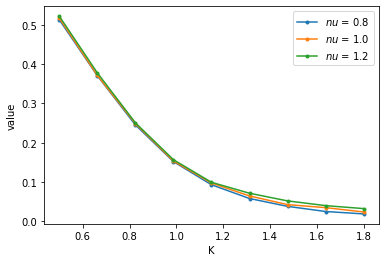

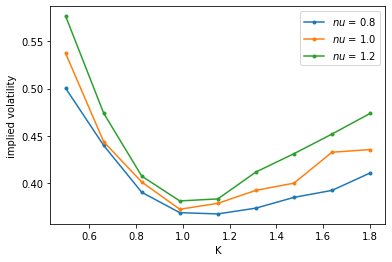

In [16]:
F0 = 1.0
T = 1.0
alpha0 = 0.35
beta = 0.25
nu = 1.0
rho = 0.25
K = 1.0
Nstep = 20000
Ntrace = 20000

nulist = np.linspace(0.8,1.2,3)
Klist = np.linspace(0.5,1.8,9)
vol_record3 = []
val_record3 = []
for nu in nulist:
    print('$nu$ = ' + str(nu))
    vol_list = []
    val_list = []
    for K in Klist:
        mean_value,std_value = get_value(F0 = F0, T = T, alpha0 = alpha0, beta = beta, nu = nu,
        rho = rho, K=K, Nstep=Nstep, Ntrace=Ntrace)
        vol = find_vol(target_value = mean_value,F0=F0, T=T,K=K)
        vol_list.append(vol)
        val_list.append(mean_value)

    vol_record3.append(vol_list)
    val_record3.append(val_list)

# make plots
plt.figure()
count = 0
for val in val_record3:
    nu = nulist[count]
    count += 1
    plt.plot(Klist,val,'.-',label = "$nu$ = "+str(nu))

plt.legend()
plt.xlabel('K')
plt.ylabel('value')
plt.figure()

count = 0
for vol in vol_record3:
    nu = nulist[count]
    count += 1
    plt.plot(Klist,vol,'.-',label = "$nu$ = "+str(nu))

plt.legend()
plt.xlabel('K')
plt.ylabel('implied volatility')

$\rho$ Dynamics


rho = -0.25
rho = 0.0
rho = 0.25


Text(0, 0.5, 'implied volatility')

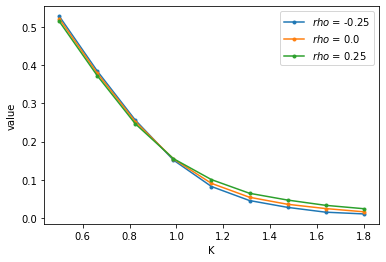

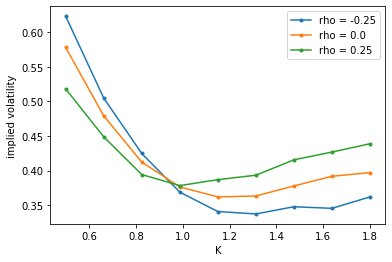

In [13]:
F0 = 1.0
T = 1.0
alpha0 = 0.35
beta = 0.25
nu = 1.0
rho = 0.25
K = 1.0
Nstep = 20000
Ntrace = 20000

rholist = np.linspace(-0.25,0.25,3)
Klist = np.linspace(0.5,1.8,9)
vol_record3 = []
val_record3 = []
for rho in rholist:
    print('rho = ' + str(rho))
    vol_list = []
    val_list = []
    for K in Klist:
        mean_value,std_value = get_value(F0 = F0, T = T, alpha0 = alpha0, beta = beta, nu = nu,
        rho = rho, K=K, Nstep=Nstep, Ntrace=Ntrace)
        vol = find_vol(target_value = mean_value,F0=F0, T=T,K=K)
        vol_list.append(vol)
        val_list.append(mean_value)

    vol_record3.append(vol_list)
    val_record3.append(val_list)

# make plots
plt.figure()
count = 0
for val in val_record3:
    rho = rholist[count]
    count += 1
    plt.plot(Klist,val,'.-',label = "$rho$ = "+str(rho))

plt.legend()
plt.xlabel('K')
plt.ylabel('value')
plt.figure()

count = 0
for vol in vol_record3:
    rho = rholist[count]
    count += 1
    plt.plot(Klist,vol,'.-',label = "rho = "+str(rho))

plt.legend()
plt.xlabel('K')
plt.ylabel('implied volatility')

## $\alpha$ Dynamics

alpha = 0.25
alpha = 0.3
alpha = 0.35


Text(0, 0.5, 'implied volatility')

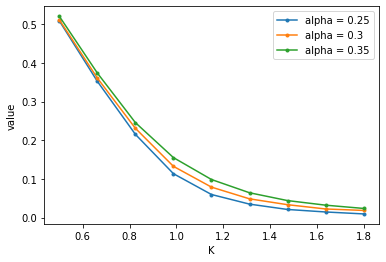

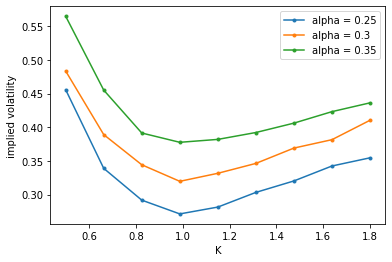

In [12]:
F0 = 1.0
T = 1.0
alpha0 = 0.35
beta = 0.25
nu = 1.0
rho = 0.25
K = 1.0
Nstep = 20000
Ntrace = 20000

alphalist = np.linspace(0.25,0.35,3)
Klist = np.linspace(0.5,1.8,9)
vol_record3 = []
val_record3 = []
for alpha0 in alphalist:
    print('alpha = ' + str(alpha0))
    vol_list = []
    val_list = []
    for K in Klist:
        mean_value,std_value = get_value(F0 = F0, T = T, alpha0 = alpha0, beta = beta, nu = nu,
        rho = rho, K=K, Nstep=Nstep, Ntrace=Ntrace)
        vol = find_vol(target_value = mean_value,F0=F0, T=T,K=K)
        vol_list.append(vol)
        val_list.append(mean_value)

    vol_record3.append(vol_list)
    val_record3.append(val_list)

# make plots
plt.figure()
count = 0
for val in val_record3:
    alpha0 = alphalist[count]
    count += 1
    plt.plot(Klist,val,'.-',label = "alpha = "+str(alpha0))

plt.legend()
plt.xlabel('K')
plt.ylabel('value')
plt.figure()

count = 0
for vol in vol_record3:
    alpha0 = alphalist[count]
    count += 1
    plt.plot(Klist,vol,'.-',label = "alpha = "+str(alpha0))

plt.legend()
plt.xlabel('K')
plt.ylabel('implied volatility')

## $\beta$ Dynamics

beta = 0.0
beta = 0.5
beta = 1.0


Text(0, 0.5, 'implied volatility')

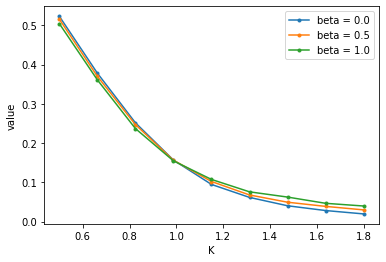

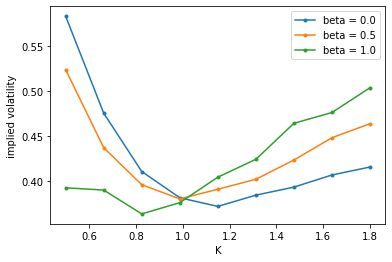

In [11]:
F0 = 1.0
T = 1.0
alpha0 = 0.35
beta = 0.25
nu = 1.0
rho = 0.25
K = 1.0
Nstep = 20000
Ntrace = 30000

betalist = np.linspace(0.,1.,3)
Klist = np.linspace(0.5,1.8,9)
vol_record3 = []
val_record3 = []
for beta in betalist:
    print('beta = ' + str(beta))
    vol_list = []
    val_list = []
    for K in Klist:
        mean_value,std_value = get_value(F0 = F0, T = T, alpha0 = alpha0, beta = beta, nu = nu,
        rho = rho, K=K, Nstep=Nstep, Ntrace=Ntrace)
        vol = find_vol(target_value = mean_value,F0=F0, T=T,K=K)
        vol_list.append(vol)
        val_list.append(mean_value)

    vol_record3.append(vol_list)
    val_record3.append(val_list)

# make plots
plt.figure()
count = 0
for val in val_record3:
    beta = betalist[count]
    count += 1
    plt.plot(Klist,val,'.-',label = "beta = "+str(beta))

plt.legend()
plt.xlabel('K')
plt.ylabel('value')
plt.figure()

count = 0
for vol in vol_record3:
    beta = betalist[count]
    count += 1
    plt.plot(Klist,vol,'.-',label = "beta = "+str(beta))

plt.legend()
plt.xlabel('K')
plt.ylabel('implied volatility')
